This notebook is all about testing how robust early stopping is to random initialization. It's focusing on smaller datasets, Nations and Kinships, which even in their small size illustrates two different patterns of effect of random initialization.

In [1]:
import getpass
import logging
import os
import random
import sys
import time
from functools import partial

import matplotlib.pyplot as plt
import pykeen
import seaborn as sns
from IPython.display import set_matplotlib_formats
from pykeen.pipeline import pipeline
from multiprocessing import Pool, cpu_count
from tqdm.auto import trange

logging.getLogger('pykeen.evaluation.evaluator').setLevel(logging.WARNING)
logging.getLogger('pykeen.stoppers.early_stopping').setLevel(logging.WARNING)

set_matplotlib_formats('svg')

In [2]:
print(time.asctime())

Mon Nov  2 13:31:35 2020


In [3]:
print(getpass.getuser())

cthoyt


In [4]:
print(sys.version)

3.8.3 (default, Jul  7 2020, 13:04:12) 
[Clang 11.0.3 (clang-1103.0.32.62)]


In [5]:
print(pykeen.get_version())

1.0.6-dev


In [6]:
cmap = sns.color_palette("flare", as_cmap=True)

In [7]:
directory = os.path.join(os.path.expanduser('~'), 'Desktop')

In [8]:
CHUNKSIZE = 2

def study(model, dataset, n_replicates=None):
    rv = replicate(
        model=model,
        dataset=dataset,
        n_replicates=n_replicates or (cpu_count() * CHUNKSIZE),
    )

    fig, (lax, rax) = plt.subplots(1, 2, figsize=(12, 4))
    plot_replicates(rv, ax=lax, title=f'{dataset}/ {model}')
    plot_scatter_improvement(rv, ax=rax)
    plt.savefig(os.path.join(directory, f'{dataset.lower()}_{model.lower()}.png'), dpi=300)
    return rv

def replicate(model, dataset, n_replicates=30, mp=False, **kwargs):
    f = partial(run, model=model, dataset=dataset, **kwargs)

    if not mp:
        it = trange(n_replicates, desc=f'Replicating {dataset}/{model}')
        rv = list(map(f, it))
    else:
        it = range(n_replicates)
        with Pool(cpu_count()) as pool:
            rv = pool.map(f, it, CHUNKSIZE)
            rv = list(rv)
    return rv
    
def run(_i, **kwargs):
    return pipeline(
        stopper='early',
        device='cpu',
        random_seed=random.randint(1, 2**15),
        stopper_kwargs=dict(patience=5, frequency=5),
        training_kwargs=dict(num_epochs=500, use_tqdm=False),
        evaluation_kwargs=dict(tqdm_kwargs=dict(leave=False)),
        **kwargs,
    )

def plot_scatter_improvement(results, ax=None):
    if ax is None:
        ax = plt.gca()

    x, y = zip(*[
        (r.stopper.best_epoch, r.stopper.improvement)
        for r in results
    ])
    sns.scatterplot(x=x, y=y, ax=ax)
    ax.set_title('Improvement vs. Epochs')
    ax.set_xlabel('Best Epoch')
    ax.set_ylabel(f'Improvement on {results[0].stopper.metric}')

def plot_replicates(results, ax=None, title=None):
    if ax is None:
        ax = plt.gca()

    max_improvement = max(r.stopper.improvement for r in results)
    min_improvement = min(r.stopper.improvement for r in results)
    var_improvement = max_improvement - min_improvement

    for r in results:    
        rel_improvement = (r.stopper.improvement - min_improvement) / var_improvement
        r.plot_early_stopping(ax=ax, lineplot_kwargs=dict(color=cmap(rel_improvement)))
    
    if title is not None:
        ax.set_title(title)

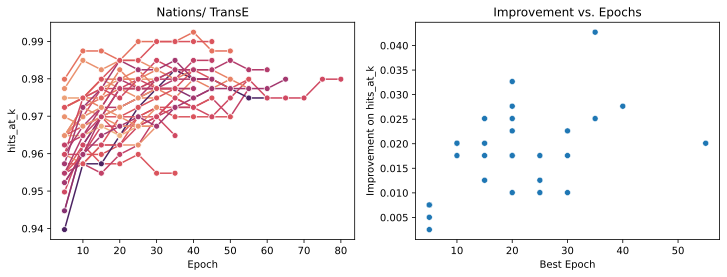

In [9]:
nations_transe_results = study(
    model='TransE',
    dataset='Nations',
)
plt.show()

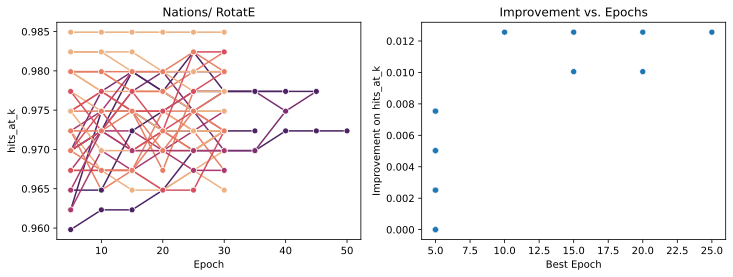

In [10]:
rotate_nations_results = study(
    model='RotatE',
    dataset='Nations',
)
plt.show()

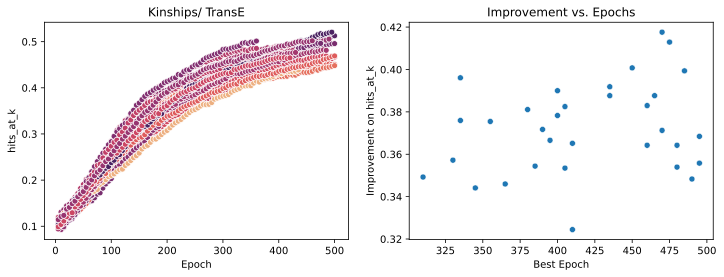

In [11]:
kinships_transe_results = study(
    model='TransE',
    dataset='Kinships',
)
plt.show()

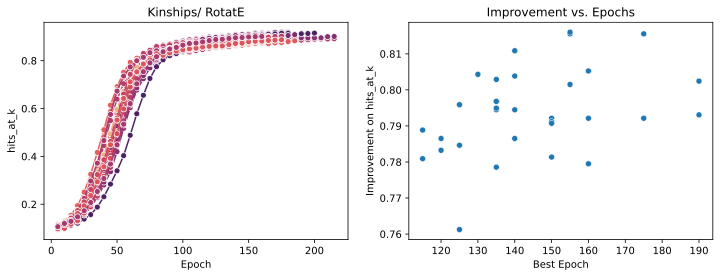

In [12]:
kinships_rotate_results = study(
    model='RotatE',
    dataset='Kinships',
)
plt.show()